# 0.라이브러리 및 데이터셋 생성

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#데이터셋 로드
df = pd.read_csv('dataset_clean.csv')

#track_id 제거
df.drop('track_id', axis=1, inplace=True)

In [15]:
df

,title,artist,duration,main_genres,sub_genres,releaseDate,explicit,acousticness,danceability,energy,...,key,liveness,loudness,mode,speechiness,tempo,timeSignature,valence,popularity,status
0,",",Dasutt,255,인디,락/메탈,2020-03-07T00:00:00+00:00,False,0.36,0.32,0.72,...,8,0.12,-3.73,0,0.05,131.62,4,0.15,29,relax
1,007 (feat. Syd),"Syd, Tabber",205,알앤비/소울,랩/힙합,2022-09-21T00:00:00+00:00,True,0.18,0.63,0.56,...,10,0.34,-8.13,0,0.12,148.68,4,0.88,50,relax
2,10 Years Ago,FKJ,200,팝,팝,2019-11-12T00:00:00+00:00,False,0.59,0.54,0.22,...,2,0.13,-11.87,0,0.07,80.00,4,0.22,47,reading
3,100 Roses,FKJ,248,팝,팝,2019-11-12T00:00:00+00:00,False,0.75,0.61,0.38,...,4,0.31,-10.00,0,0.07,82.97,4,0.20,42,reading
4,2 O' CLOCK,dori,152,알앤비/소울,알앤비/소울,2022-02-01T00:00:00+00:00,False,0.67,0.82,0.64,...,9,0.10,-5.56,1,0.05,92.04,4,0.74,55,drive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,紅蓮華,LiSA,237,팝,J-POP,2019-04-22T00:00:00+00:00,False,0.00,0.54,0.98,...,4,0.08,-2.83,0,0.16,134.94,4,0.26,74,work out
644,활주 - Live,BUZZ,215,OST,OST,2006-12-19T00:00:00+00:00,False,0.01,0.16,0.99,...,1,0.66,-2.30,0,0.17,164.09,4,0.22,4,work out
645,暁の鎮魂歌,Linked Horizon,240,J-POP,OST,2018-09-19T00:00:00+00:00,False,0.40,0.50,0.82,...,2,0.37,-6.29,0,0.04,136.90,3,0.30,56,work out
646,휴가철 도로 위 Vacation Freeway,Yun DDan DDan,194,포크/어쿠스틱,인디,2017-06-05T00:00:00+00:00,False,0.55,0.62,0.62,...,10,0.22,-5.27,1,0.04,89.03,4,0.63,0,drive


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             648 non-null    object 
 1   artist            648 non-null    object 
 2   duration          648 non-null    int64  
 3   main_genres       648 non-null    object 
 4   sub_genres        648 non-null    object 
 5   releaseDate       648 non-null    object 
 6   explicit          648 non-null    bool   
 7   acousticness      648 non-null    float64
 8   danceability      648 non-null    float64
 9   energy            648 non-null    float64
 10  instrumentalness  648 non-null    float64
 11  key               648 non-null    int64  
 12  liveness          648 non-null    float64
 13  loudness          648 non-null    float64
 14  mode              648 non-null    int64  
 15  speechiness       648 non-null    float64
 16  tempo             648 non-null    float64
 1

# 1.Catboost 모델 학습

## (1)학습 : 디폴트
하이퍼파라미터 튜닝 없이 진행

In [3]:
#1차 분할 (train/test)
X = df.drop(['status'], axis=1)
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

#2차 분할 (tr/val(검증 데이터)) 하이퍼파라미터 튜닝시 사용함.
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train) # 0.25 x 0.8 = 0.2
print("Training set size:", X_tr.shape)
print("Validation set size:", X_val.shape)

Train set size: (518, 20)
Test set size: (130, 20)
Training set size: (388, 20)
Validation set size: (130, 20)


In [7]:
#카테고리형 변수 지정 
cat_cols = ['artist', 'explicit', 'mode', 'main_genres', 'sub_genres', 'releaseDate']
cat_features = [X_train.columns.get_loc(c) for c in cat_cols] #카테고리형 변수 인덱스 리스트 생성

#모델 학습(디폴트)
model = CatBoostClassifier()

model.fit(X_train, y_train, cat_features=cat_features, verbose=0)
y_pred = model.predict(X_test)
print("test Accuracy:", accuracy_score(y_test, y_pred))

#과적합 확인용
#train데이터 셋의 정확도가 test데이터 셋의 정확도보다 훨씬 높으면 과적합 의심
y_train_pred = model.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

test Accuracy: 0.7538461538461538
Train Accuracy: 0.944015444015444


In [21]:
# 지표 출력
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       drive       0.50      0.45      0.47        20
     reading       0.74      0.58      0.65        24
       relax       0.80      0.87      0.83        63
    work out       0.83      0.87      0.85        23

    accuracy                           0.75       130
   macro avg       0.72      0.69      0.70       130
weighted avg       0.75      0.75      0.75       130



In [22]:
#Test 예측에 대한 임계값 출력
proba_df = pd.DataFrame(
    model.predict_proba(X_test).round(2), # 임계값
    columns=model.classes_ #각 클래스별 이름
)
proba_df

,drive,reading,relax,work out
0,0.00,0.00,1.00,0.00
1,0.04,0.03,0.02,0.92
2,0.00,0.00,0.99,0.00
3,0.52,0.13,0.34,0.01
4,0.29,0.41,0.27,0.03
...,...,...,...,...
125,0.09,0.87,0.03,0.01
126,0.03,0.56,0.40,0.01
127,0.01,0.00,0.99,0.00
128,0.01,0.76,0.23,0.00


In [23]:
# 예측값의 임계값이 0.5이하인 경우
y_pred_proba = model.predict_proba(X_test)[:, 1]
low_confidence_indices = np.where(y_pred_proba < 0.5)[0]
low_confidence_samples = y_test.iloc[low_confidence_indices]
low_confidence_samples.value_counts()

status
relax       62
work out    22
drive       18
reading     11
Name: count, dtype: int64

## (2)학습 : 하이퍼파라미터 조정_1

In [5]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

주요 파라미터

iterations : 최대 트리 개수(부스팅 반복 수). 많을수록 학습 능력 ↑ (하지만 과적합 위험 ↑) / 디폴트:500 


learning_rate : 학습률. 각 트리 업데이트 기여도. 낮을수록 안정적이지만 iterations↑ 필요 / 디폴트 : 0.009 

depth :	트리 깊이. 모델 복잡도 제어 (큰 값일수록 복잡)	/ 디폴트 : 6 

l2_leaf_reg	L2 : 정규화 계수. 클수록 과적합 완화	/ 디폴트:3 


In [ ]:
#카테고리형 변수 지정 
cat_cols = ['artist', 'explicit', 'mode','main_genres', 'sub_genres', 'releaseDate']
cat_features = [X_tr.columns.get_loc(c) for c in cat_cols] #카테고리형 변수 인덱스 리스트 생성

# 하이퍼파라미터 탐색값 정의
search_space = {
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)), #학습률(각 트리 업데이트 기여도)
    'iterations' : hp.quniform('iterations', 100, 1000, 10), #트리 개수
    'depth' : hp.quniform('depth', 3, 10, 1), #트리 깊이
    'l2_leaf_reg' : hp.quniform('l2_leaf_reg', 1, 10, 1) #L2 정규화 계수
}


# 목적함수 정의()
def objective_func(params):
    cgb_model = CatBoostClassifier(learning_rate=params['learning_rate'],
                                   iterations=int(params['iterations']),
                                   depth=int(params['depth']),
                                   l2_leaf_reg=int(params['l2_leaf_reg']),
                                   cat_features=cat_features,
                                   random_state=42,
                                   verbose=0)
    
    #하이퍼파라미터 검증용
    cgb_model.fit(X_tr, y_tr,
                  eval_set=(X_val, y_val),
                  cat_features=cat_features,
                  early_stopping_rounds=50)

    preds = cgb_model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)

    return {'loss':-accuracy, 'status': STATUS_OK} 

# 입력 결과값 저장 Trials 객체 생성
trials_val = Trials()


# 최적 파라미터 탐색 수행
best = fmin(fn=objective_func, # 목적함수
            space=search_space, #하이퍼파라미터 탐색 공간
            algo=tpe.suggest, #탐색 알고리즘(대표적으로 tpe를 많이씀.)
            max_evals=50, #최대 반복 횟수
            trials=trials_val, #기록 저장 객체
            rstate=np.random.default_rng(seed=42)) # 랜덤시드
print("Best Hyperparameters:", best)


best loss: -0.9461538461538461
 
Best Hyperparameters: {'depth': 10.0, 'iterations': 920.0, 'l2_leaf_reg': 3.0, 'learning_rate': 0.06288765437301348}

In [ ]:
#과적합 유무 확인

#탐색된 최적 파라미터
best_params = {'learning_rate': 0.06288765437301348,
                'iterations': 920,
                'depth': 10,
                'l2_leaf_reg': 3}

#최적 파라미터로 val, tr 데이터셋 비교
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features, 
                           random_state=42, 
                           verbose=0)

model.fit(X_tr, y_tr,early_stopping_rounds=50)

# tr 성능
tr_preds = model.predict(X_tr)
tr_accuracy = accuracy_score(y_tr, tr_preds)
print(f"Training Set Accuracy : {tr_accuracy}")

# val 성능
val_preds = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_preds)
print(f'Validation Accuracy : {val_accuracy}')


Training Set Accuracy : 0.9561855670103093
Validation Accuracy : 0.6923076923076923


과적합 확인

노래 자체의 특징으로만 모델이 학습할 수 있도록 

title, releaseDate 변수를 제거 후 재진행

In [ ]:
X_tr1 = X_tr.copy()
X_val1 = X_val.copy()

X_tr1.drop(['title', 'releaseDate'], axis=1, inplace=True)
X_val1.drop(['title', 'releaseDate'], axis=1, inplace=True)

In [ ]:
cat_cols = ['artist', 'explicit', 'mode','main_genres', 'sub_genres']  #카테고리형 변수 지정
cat_features = [X_tr1.columns.get_loc(c) for c in cat_cols] #카테고리형 변수 인덱스 리스트 생성

In [ ]:
#과적합 유무 확인

#탐색된 최적 파라미터
best_params = {'learning_rate': 0.06288765437301348,
                'iterations': 920,
                'depth': 10,
                'l2_leaf_reg': 3}

#최적 파라미터로 val, tr 데이터셋 비교
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features, 
                           random_state=42, 
                           verbose=0)

model.fit(X_tr, y_tr,early_stopping_rounds=50)

# tr 성능
tr_preds = model.predict(X_tr1)
tr_accuracy = accuracy_score(y_tr, tr_preds)
print(f"Training Set Accuracy : {tr_accuracy}")

# val 성능
val_preds = model.predict(X_val1)
val_accuracy = accuracy_score(y_val, val_preds)
print(f'Validation Accuracy : {val_accuracy}')


Training Set Accuracy : 0.9458762886597938
Validation Accuracy : 0.6923076923076923


일부 변수를 변경하더라도 모델에서 과적합 현상이 지속적으로 발생하였다.
이는 단순히 트리의 복잡도 문제라기보다는, 일부 피처가 예측에 과도하게 기여하고 있을 가능성이 있다.

특히 트리 기반 모델의 경우,

특정 피처가 상위 노드에서 반복적으로 분할 기준으로 선택되면

해당 피처에 모델이 과도하게 의존하면서 훈련 데이터에 특화된 규칙을 학습할 수 있다.

이러한 경우, 모델의 전체 성능은 높게 나타나지만
검증 데이터 또는 테스트 데이터에서는 일반화 성능이 저하되는 과적합이 발생할 수 있다.

따라서 본 문제에서는

트리에서 주요하게 사용되는 피처들의 중요도를 분석하고

과도한 영향력을 가지는 피처에 대해 제거 또는 변환 등의 전처리를 수행하는 것이 필요하다고 판단됨.

In [ ]:
#Feature Importance

fi = model.feature_importances_
fi_col = X_tr.columns

fi_df = pd.DataFrame({'feature' : fi_col,
                      'importance' : fi}).sort_values('importance', ascending=False)

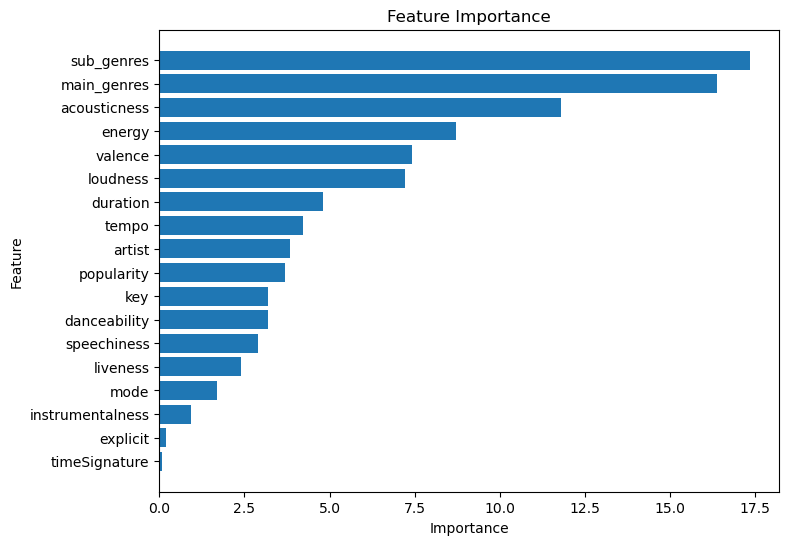

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # 중요도가 큰 피처가 위로 오게

plt.show()

feature importance 분석 결과, sub_genres와 main_genres가 예측에 과도하게 기여하고 있음을 확인하였다.(둘이 합쳐서 30%)

이는 장르 정보를 직접적으로 포함하는 피처로 인해 모델이 일반적인 오디오 특성보다는 라벨에 가까운 정보를 학습했을 가능성을 시사한다.

이에 따라 해당 피처를 제거하고 오디오 피쳐 중심의 모델로 재학습을 진행한다.(artist도 제거 진행)

In [ ]:
X_tr2 = X_tr.copy()
X_val2 = X_val.copy()

X_tr2.drop(['title', 'releaseDate'], axis=1, inplace=True)
X_val2.drop(['title', 'releaseDate'], axis=1, inplace=True)
cat_cols = ['explicit', 'mode', 'sub_genres', 'main_genres', 'artist']  #카테고리형 변수 지정
cat_features = [X_tr2.columns.get_loc(c) for c in cat_cols] #카테고리형 변수 인덱스 리스트 생성
#과적합 유무 확인

#탐색된 최적 파라미터
best_params = {'learning_rate': 0.06288765437301348,
                'iterations': 920,
                'depth': 10,
                'l2_leaf_reg': 3}

#최적 파라미터로 val, tr 데이터셋 비교
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features, 
                           random_state=42, 
                           verbose=0)

model.fit(X_tr2, y_tr,early_stopping_rounds=50)

# tr 성능
tr_preds = model.predict(X_tr2)
tr_accuracy = accuracy_score(y_tr, tr_preds)
print(f"Training Set Accuracy : {tr_accuracy}")

# val 성능
val_preds = model.predict(X_val2)
val_accuracy = accuracy_score(y_val, val_preds)
print(f'Validation Accuracy : {val_accuracy}')


Training Set Accuracy : 0.9458762886597938
Validation Accuracy : 0.6923076923076923


Training set에서는 정확도가 매우 높게 나타났으나(≈0.99),
Validation set에서는 성능이 크게 하락(≈0.58)하여 과적합이 발생하고 있음을 확인하였다.

음악 피쳐 외 변수들을 제거한 이후에도 과적합 현상이 지속되는 것으로 보아,
문제의 원인은 특정 변수보다는 트리 기반 모델의 복잡도 자체에 기인한 것으로 판단된다.
이에 따라 일부 성능 저하는 감수하더라도, max_depth를 낮추어 모델의 복잡도를 제한하는 방향으로 개선을 진행한다.

Feature importance 분석 결과, sub_genres와 main_genres는 장르 분류 문제의 특성상
예측에 유의미한 정보를 제공하는 것으로 확인되었으며, 피처 자체에 구조적인 문제는 없다고 판단하였다.

해당 피처를 제외한 상태에서도 과적합이 완전히 해소되지 않았다는 점을 고려하여,
피처 구성은 유지하되 모델 복잡도 조절을 중심으로 개선을 진행한다.

이에 따라 이전 실험에서 제외했던 장르 및 아티스트 관련 피처를 다시 포함하여 모델을 재학습한다.

In [ ]:
# 1~9 depth 학습
depths = np.arange(1,10)

for i in depths:
    #탐색된 최적 파라미터
    best_params = {'learning_rate': 0.06288765437301348,
                    'iterations': 920,
                    'depth': i,
                    'l2_leaf_reg': 3}

    #최적 파라미터로 val, tr 데이터셋 비교
    model = CatBoostClassifier(**best_params, 
                            cat_features=cat_features, 
                            random_state=42, 
                            verbose=0)

    model.fit(X_tr2, y_tr,early_stopping_rounds=50)
    
    print(f'depth : {i} 성능')

    # tr 성능
    tr_preds = model.predict(X_tr2)
    tr_accuracy = accuracy_score(y_tr, tr_preds)
    print(f"Training Set Accuracy : {tr_accuracy}")

    # val 성능
    val_preds = model.predict(X_val2)
    val_accuracy = accuracy_score(y_val, val_preds)
    print(f'Validation Accuracy : {val_accuracy}')
    print(f'Gap : {tr_accuracy - val_accuracy}')

depth : 1 성능
Training Set Accuracy : 0.8530927835051546
Validation Accuracy : 0.6615384615384615
Gap : 0.1915543219666931
depth : 2 성능
Training Set Accuracy : 0.9020618556701031
Validation Accuracy : 0.7
Gap : 0.20206185567010315
depth : 3 성능
Training Set Accuracy : 0.9407216494845361
Validation Accuracy : 0.7153846153846154
Gap : 0.22533703409992067
depth : 4 성능
Training Set Accuracy : 0.9432989690721649
Validation Accuracy : 0.7307692307692307
Gap : 0.2125297383029342
depth : 5 성능
Training Set Accuracy : 0.9484536082474226
Validation Accuracy : 0.7307692307692307
Gap : 0.21768437747819191
depth : 6 성능
Training Set Accuracy : 0.9561855670103093
Validation Accuracy : 0.7076923076923077
Gap : 0.2484932593180016
depth : 7 성능
Training Set Accuracy : 0.9536082474226805
Validation Accuracy : 0.7153846153846154
Gap : 0.23822363203806507
depth : 8 성능
Training Set Accuracy : 0.9561855670103093
Validation Accuracy : 0.7076923076923077
Gap : 0.2484932593180016
depth : 9 성능
Training Set Accuracy 

depth를 증가시킴에 따라 validation accuracy는 depth=4~5 구간에서 최고치를 보였으며,

이후 depth가 증가할수록 training accuracy는 상승하는 반면 validation accuracy는 감소하는 과적합 양상이 나타났다.

이에 따라 본 분석에서는 depth=4를 모델 복잡도와 일반화 성능 간 균형점으로 선택하였다.



depth 고정 후 hyperopt 재설계를 진행

- 이때 제목, 날짜 피쳐는 모델 방향성과 맞지 않다고 판단해서 제외를 함.

In [ ]:
X_tr3 = X_tr.copy()
X_tr3.drop(['title','releaseDate'], axis=1, inplace=True)

X_val3 = X_val.copy()
X_val3.drop(['title','releaseDate'], axis=1, inplace=True)


cat_cols = ['artist', 'explicit', 'mode','main_genres', 'sub_genres']  #카테고리형 변수 지정
cat_features = [X_tr3.columns.get_loc(c) for c in cat_cols] #카테고리형 변수 인덱스 리스트 생성

In [ ]:
# 하이퍼파라미터 탐색값 정의
search_space = {
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)), #학습률(각 트리 업데이트 기여도)
    'iterations' : hp.quniform('iterations', 100, 1000, 10), #트리 개수
    'l2_leaf_reg' : hp.quniform('l2_leaf_reg', 1, 10, 1) #L2 정규화 계수
}


# 목적함수 정의()
def objective_func(params):
    cgb_model = CatBoostClassifier(learning_rate=params['learning_rate'],
                                   iterations=int(params['iterations']),
                                   depth=4,
                                   l2_leaf_reg=int(params['l2_leaf_reg']),
                                   cat_features=cat_features,
                                   random_state=42,
                                   verbose=0)
    
    #하이퍼파라미터 검증용
    cgb_model.fit(X_tr3, y_tr,
                  eval_set=(X_val3, y_val), #학습에는 쓰지 않지만, 학습 중 성능을 평가하는 데이터
                  cat_features=cat_features,
                  early_stopping_rounds=50)
    
    #교차 검증을 통한 loss 계산(K-Fold=5)
    score = cross_val_score(cgb_model, X_tr3, y_tr, cv=5, scoring='accuracy')
    acc = np.mean(score)
    return {'loss': -acc, 'status': STATUS_OK}

# 입력 결과값 저장 Trials 객체 생성
trials_val = Trials()


# 최적 파라미터 탐색 수행
best = fmin(fn=objective_func, # 목적함수
            space=search_space, #하이퍼파라미터 탐색 공간
            algo=tpe.suggest, #탐색 알고리즘(대표적으로 tpe를 많이씀.)
            max_evals=50, #최대 반복 횟수
            trials=trials_val, #기록 저장 객체
            rstate=np.random.default_rng(seed=42)) # 랜덤시드
print("Best Hyperparameters:", best)


100%|██████████| 50/50 [05:09<00:00,  6.19s/trial, best loss: -0.7461538461538462]
Best Hyperparameters: {'iterations': 490.0, 'l2_leaf_reg': 5.0, 'learning_rate': 0.030207324138548857}


In [20]:
#과적합 유무 확인

#탐색된 최적 파라미터
best_params = {'learning_rate': best['learning_rate'],
                'iterations': int(best['iterations']),
                'depth': 4,
                'l2_leaf_reg': int(best['l2_leaf_reg'])}

#최적 파라미터로 val, tr 데이터셋 비교
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features, 
                           random_state=42, 
                           verbose=0)

model.fit(X_tr3, y_tr,early_stopping_rounds=50)

# tr 성능
tr_preds = model.predict(X_tr3)
tr_accuracy = accuracy_score(y_tr, tr_preds)
print(f"Training Set Accuracy : {tr_accuracy}")

# val 성능
val_preds = model.predict(X_val3)
val_accuracy = accuracy_score(y_val, val_preds)
print(f'Validation Accuracy : {val_accuracy}')



Training Set Accuracy : 0.9432989690721649
Validation Accuracy : 0.7384615384615385


Accuracy 차이가 0.204 정도 난다.


여전히 Train–Validation 간 성능 차이가 크게 나타나 과적합 문제가 완전히 해소되지 않았다.
이에 따라 모델의 일반화 성능을 개선하기 위해 샘플링 기반 규제 기법을 추가로 적용하였다.


subsample : 각 트리를 학습할 때, 전체 학습 데이터 중 n%만 랜덤으로 사용
- 모든 트리가 같은 데이터만 보지 않게 되어 과적합 감소

rsm : 각 트리를 만들 때, 전체 피처 중 n%만 랜덤으로 사용
- 트리 간 유사성을 낮추어 특정 피처에 대한 과도한 의존을 방지

In [29]:
#과적합 유무 확인

#탐색된 최적 파라미터
best_params = {'learning_rate': best['learning_rate'],
                'iterations': int(best['iterations']),
                'depth': 4,
                'l2_leaf_reg': int(best['l2_leaf_reg']),
                'bootstrap_type':'Bernoulli',
                'subsample':0.8,
                'rsm':0.8,}

#최적 파라미터로 val, tr 데이터셋 비교
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features, 
                           random_state=42, 
                           verbose=0)

model.fit(X_tr3, y_tr,early_stopping_rounds=50)

# tr 성능
tr_preds = model.predict(X_tr3)
tr_accuracy = accuracy_score(y_tr, tr_preds)
print(f"Training Set Accuracy : {tr_accuracy}")

# val 성능
val_preds = model.predict(X_val3)
val_accuracy = accuracy_score(y_val, val_preds)
print(f'Validation Accuracy : {val_accuracy}')



Training Set Accuracy : 0.9561855670103093
Validation Accuracy : 0.7384615384615385


샘플링 기반 규제(subsample, rsm)를 적용하여 모델의 복잡도를 추가로 제한하였으나,
Train–Validation 간 성능 차이는 여전히 유의미하게 관측되었다.

이러한 결과로 미루어 볼 때, 과적합의 원인은 모델 설정이나 학습 방식보다는
문제 정의 및 타겟 변수 자체의 특성에 기인했을 가능성이 높다고 판단된다.

특히 타겟 변수인 status(청취 상황)는 본질적으로 경계가 명확하지 않은 라벨로 구성되어 있다.
예를 들어 운동 / 휴식 / 독서 / 드라이브와 같은 청취 상황은 상호 배타적이지 않으며,
동일한 음악이 여러 상황에 동시에 적합할 수 있다.

즉, 입력 피처가 충분하더라도 라벨 간 중첩과 불확실성으로 인해
모델이 달성할 수 있는 이론적 최대 성능 자체가 제한되는 문제이며,
이는 Bayes Error가 상대적으로 큰 문제 설정으로 해석할 수 있다.

Bayes Error란,
주어진 입력 피처가 완벽하더라도 이론적으로 최소한으로 발생할 수밖에 없는 오류율을 의미한다.

이는 데이터에 내재된 노이즈, 라벨의 모호성, 클래스 간 중첩 등으로 인해 발생하며,
어떠한 모델을 사용하더라도 이를 완전히 제거할 수는 없다.

본 프로젝트의 경우,
청취 상황이라는 타겟 변수는 개인의 주관과 맥락에 크게 의존하며
라벨 간 경계가 명확하지 않다는 특성을 가진다.
따라서 동일한 음악이 여러 상황에 적합하게 인식될 수 있고,
이로 인해 모델 성능에는 구조적인 한계(Bayes Error)가 존재한다고 판단된다.

## 최종 모델
가장 Validation 성능이 안정적인 파라미터를 선택하여 진행

In [9]:
#피쳐 조정
X_train_final = X_train.drop(['title', 'releaseDate'], axis=1)
X_test_final = X_test.drop(['title', 'releaseDate'], axis=1)

#범주형 변수 지정
cat_cols = ['artist', 'main_genres', 'sub_genres', 'explicit', 'mode']
cat_features_train = [X_train_final.columns.get_loc(c) for c in cat_cols] #인덱스 리스트 생성

In [12]:
#hyperopt로 받은 최적의 파라미터
best_params = {'learning_rate': best['learning_rate'],
                'iterations': int(best['iterations']),
                'depth': 4,
                'l2_leaf_reg': int(best['l2_leaf_reg'])}

#모델 생성
model = CatBoostClassifier(**best_params, 
                           cat_features=cat_features_train, 
                           random_state=42, 
                           verbose=0)
#모델 학습
model.fit(
    X_train_final,
    y_train,
    eval_set=(X_test_final, y_test),
    early_stopping_rounds=50,
    verbose=0
)

# class 예측
y_train_pred = model.predict(X_train_final)
y_test_pred  = model.predict(X_test_final)

# 확률 예측 (ROC용)
y_test_proba = model.predict_proba(X_test_final)


In [13]:
# 성능 확인

print("Train Accuracy :", accuracy_score(y_train, y_train_pred))
print("Test Accuracy  :", accuracy_score(y_test, y_test_pred))

print("\n[Test Classification Report]")
print(classification_report(y_test, y_test_pred))

Train Accuracy : 0.8667953667953668
Test Accuracy  : 0.7461538461538462

[Test Classification Report]
              precision    recall  f1-score   support

       drive       0.62      0.40      0.48        20
     reading       0.71      0.50      0.59        24
       relax       0.75      0.87      0.81        63
    work out       0.81      0.96      0.88        23

    accuracy                           0.75       130
   macro avg       0.72      0.68      0.69       130
weighted avg       0.73      0.75      0.73       130



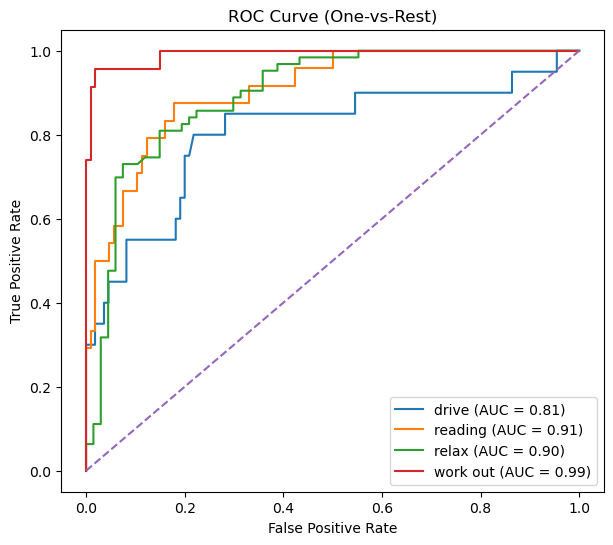

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 라벨 바이너리화
y_test_bin = label_binarize(y_test, classes=model.classes_)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()


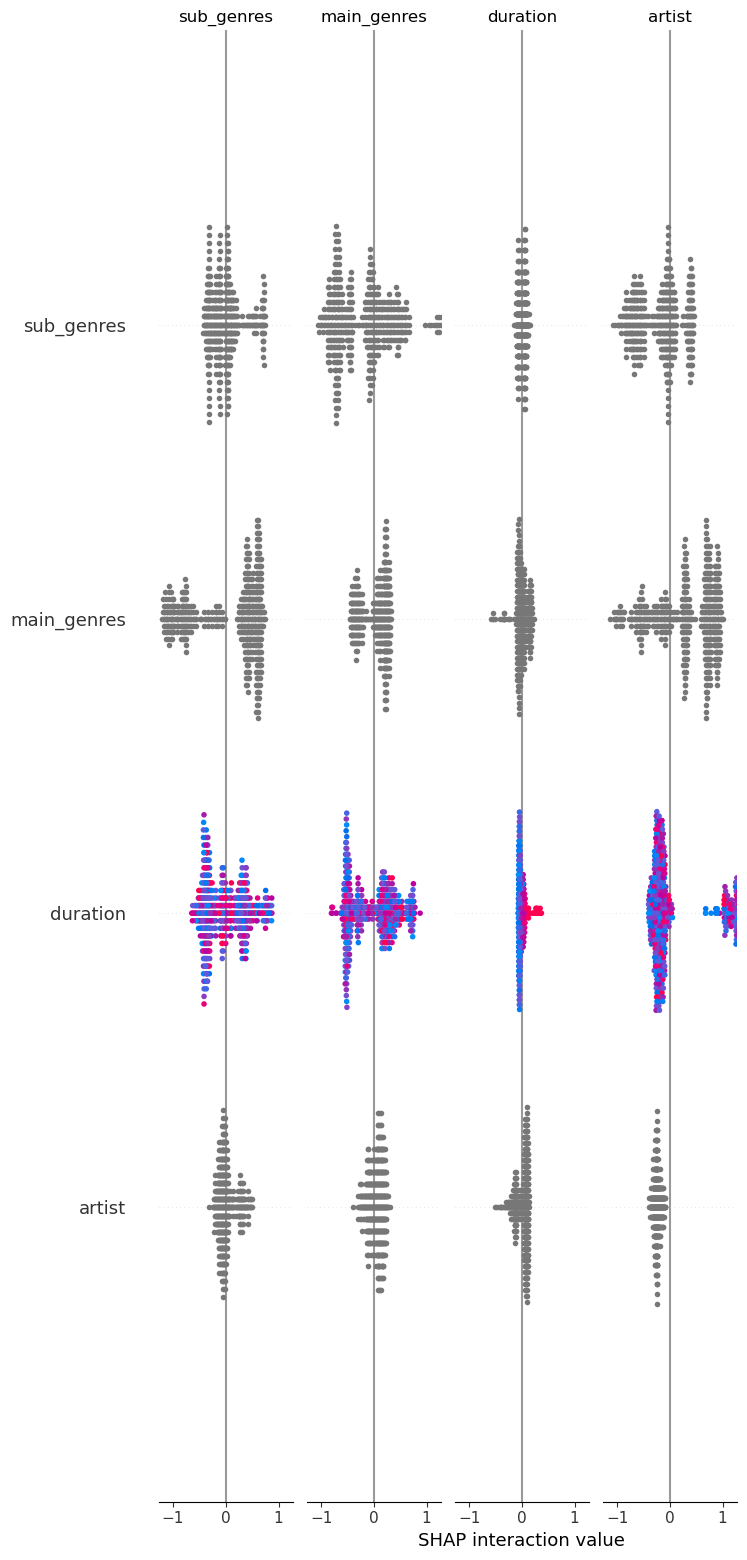

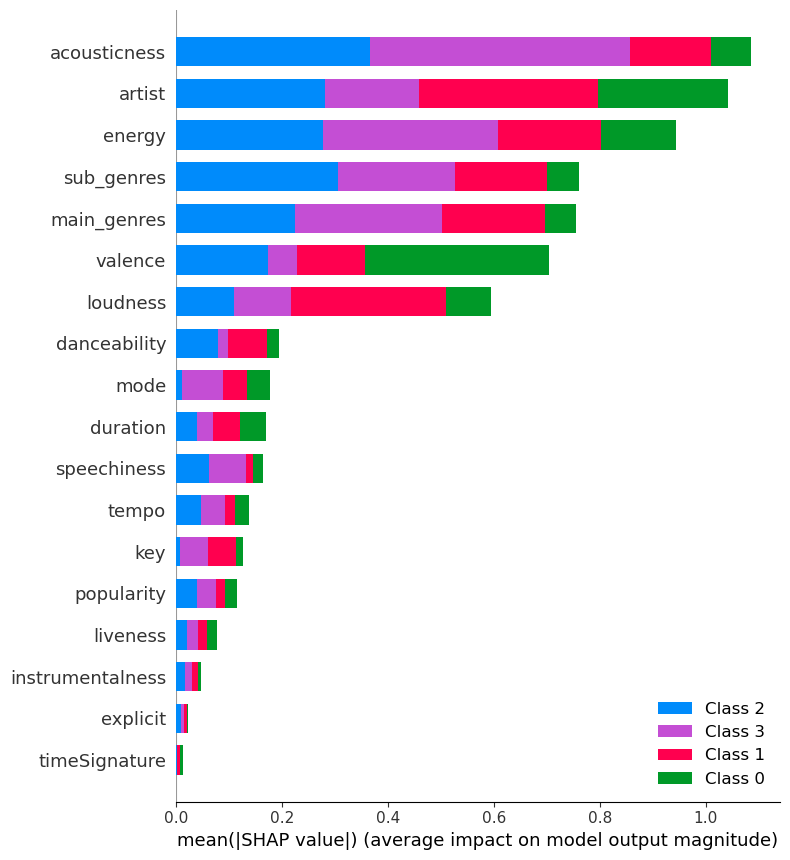

In [28]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_final)

# 1. 전체 중요도
shap.summary_plot(shap_values, X_train_final, max_display=18)

# 2. Bar plot
shap.summary_plot(shap_values, X_train_final, plot_type="bar")